In [2]:
from pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import kurtosis,skew,entropy
import eeglib
import joblib


In [3]:
types=['EEG','EOG','EMG']
exs=['mat','npy']

type=types[2]
ex=exs[1]

file_loc="D:/FYP/EEGdenoiseNet-master/EEGdenoiseNet-master/data/{0}_all_epochs.{1}".format(type,ex)
print(file_loc)

if ex=='mat':
    data=read_mat(file_loc)
    print(data.keys())
    fs=data['fs']
    epochs=data['{0}_all_epochs'.format(type)]
    print(epochs.shape)
else:
    epochs=np.load(file_loc)
    print(epochs.shape)

D:/FYP/EEGdenoiseNet-master/EEGdenoiseNet-master/data/EMG_all_epochs.npy
(5598, 512)


Making the dummy dataset

In [4]:
class Signals:
    def __init__(self,data,target,target_names, feature_names):
        self.data=data
        self.target=target
        self.target_names=target_names
        self.feature_names=feature_names

In [5]:
def hj_mobility(data,axis_=1):
    return np.sqrt(np.var(np.diff(data,axis=axis_),axis=axis_)/np.var(data,axis=axis_))

def hj_complexity(data,axis_=1):
    return hj_mobility(np.diff(data,axis=axis_),axis_=axis_)/hj_mobility(data,axis_=axis_)

In [6]:
data_train=[]
target_train=[]
data_test=[]
target_test=[]
portion =0.3
target_names=['brain','eye','muscle']
feature_names=['hj_mob','skewness','kurtosis','hj_comp']
for i,type in enumerate(types):
    file_loc="D:/FYP/EEGdenoiseNet-master/EEGdenoiseNet-master/data/{0}_all_epochs.{1}".format(types[i],exs[1])
    data_i=np.load(file_loc)
    target_i=np.array([i]*data_i.shape[0])
    target_i=target_i.reshape(1,target_i.shape[0])
    #normalise the data_i array
    mu_i=np.mean(data_i,axis=1)
    mu_i=mu_i.reshape(mu_i.shape[0],1)
    sigma_i=np.std(data_i,axis=1)
    sigma_i=sigma_i.reshape(sigma_i.shape[0],1)
    data_i=(data_i-mu_i)/sigma_i

    #mobility
    hj_mob_i=hj_mobility(data_i)
    hj_mob_i=hj_mob_i.reshape(hj_mob_i.shape[0],1)

    #complexity
    hj_comp_i=hj_complexity(data_i)
    hj_comp_i=hj_comp_i.reshape(hj_comp_i.shape[0],1)

    #skew
    skewness_i=skew(data_i,axis=1)**2
    skewness_i=skewness_i.reshape(skewness_i.shape[0],1)

    #kurtosis
    kurtosis_i=kurtosis(data_i,axis=1)**2
    kurtosis_i=kurtosis_i.reshape(kurtosis_i.shape[0],1)
    print(hj_mob_i.shape,skewness_i.shape,kurtosis_i.shape)
    data_i=np.hstack((hj_mob_i,skewness_i,kurtosis_i,hj_comp_i)).T
    if i==0:
        data=data_i
        target=target_i
    else:
        data=np.hstack((data,data_i))
        target=np.hstack((target,target_i))


(4514, 1) (4514, 1) (4514, 1)
(3400, 1) (3400, 1) (3400, 1)
(5598, 1) (5598, 1) (5598, 1)


In [7]:

Test_One=Signals(data,target,target_names,feature_names)

In [8]:
X,y=Test_One.data,Test_One.target

X=X.T
y=y.T



In [12]:
from sklearn.model_selection import train_test_split 
# i.e. 70 % training dataset and 30 % test datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, shuffle=False) 
np.random.seed(43)
indices=np.random.permutation(X_train.shape[0])
X_train=X_train[indices]
y_train=y_train[indices]

In [13]:
from sklearn.ensemble import RandomForestClassifier 

def testing_for_number_of_trees(n,X_train,y_train,X_test,y_test):
    print(n)
    clf = RandomForestClassifier(n_estimators = n,max_depth=10,oob_score=True,random_state=42)   
    clf.fit(X_train, y_train) 
    oob_error = 1 - clf.oob_score_
    print("OOB ERROR: ",oob_error)
    y_pred = clf.predict(X_test) 
    from sklearn import metrics   
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
    return clf

clf=testing_for_number_of_trees(200,X_train,y_train,X_test,y_test)

200


c:\Python310\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


OOB ERROR:  0.0
ACCURACY OF THE MODEL:  0.1714031971580817


In [42]:
import pandas as pd 
feature_imp = pd.Series(clf.feature_importances_, index = Test_One.feature_names).sort_values(ascending = False) 
feature_imp


hj_mob      0.506331
hj_comp     0.443510
kurtosis    0.041910
skewness    0.008249
dtype: float64

Save the model

In [43]:
#save the model parameters
joblib.dump(clf, "random_forest.joblib")


['random_forest.joblib']

In [14]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

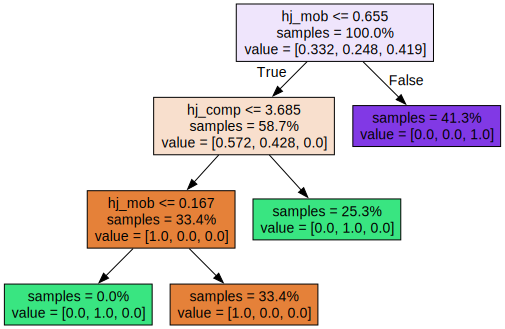

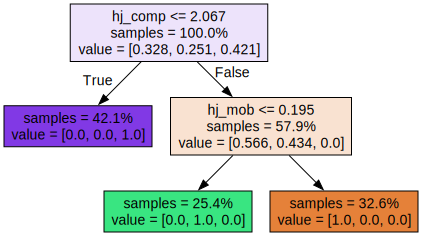

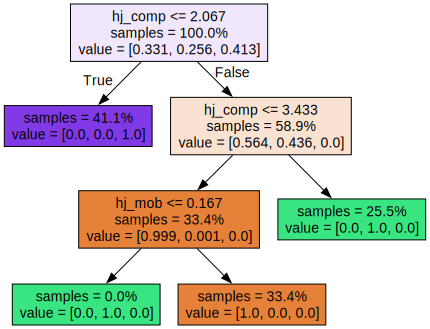

In [19]:
# Export the first three decision trees from the forest
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'


for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=Test_One.feature_names,  
                               filled=True, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [22]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average=None)
recall = recall_score(y_test, y_pred,average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 1.0
Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
